<table>
<tr>
<td width=15%><img src="../../img/UGA.png"></img></td>
<td><center><h1>Project n°3</h1></center></td>
<td width=15%><a href="https://team.inria.fr/tripop/team-members/" style="font-size: 16px; font-weight: bold">Florian Vincent</a> </td>
</tr>
</table>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from src.functions import get_dataset,classif_result

In [3]:
%load_ext autoreload
%autoreload 2

# Learning text classification

This project is heavily inspired from [Jigsaw's *Toxic Comments Classification* challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) on kaggle.
To avoid copy-pastings of foreign code, it will guide you towards specific tools to test and use.

## Overview of the project

Take a look at the *zip*ed csv data files by unzipping them (`for name in $(ls *.zip); do unzip $name; done;`).

Every comment in the train set is classified with a label in `{"toxic", "severe_toxic", "obscene", "threat", "insult", "identity hate"}`.
You will need to train multiple kind of models to identify those comments, and you will test them against the test dataset.

# Part 1: Data exploration

In [2]:
# on commence par récupérer le jeu les jeux de données
# avec la fonctions get_dataset
X_train, y_train, X_test, y_test = get_dataset()

print("dimension de X_train set : " ,X_train.shape)
print("dimension de y_train set : " ,y_train.shape)
print("dimension de X_test set : " ,X_test.shape)
print("dimension de y_test set : " ,y_test.shape)

dimension de X_train set :  (159571,)
dimension de y_train set :  (159571, 6)
dimension de X_test set :  (63978,)
dimension de y_test set :  (63978, 6)


## Study the data

Representing textual data in an algebraic format (i.e. vectors & matrices) is not easy, but fortunately it has been quickly studied earlier in the lectures.

**Implement a word-vectorizer relying on simple counting for the textual data**

On implémente ici un CountVectorizer qui sert à transformer un texte en vecteur avec un principe de comptage.
Par exemple si l'on donne la phrase "bonjour je m'appelle didier" alors la phrase sera transformer en
"bonjour","je", "appelle", "didier"
1           1       1          1

Et une fois tous les mots du data_train appris seul les mots présent dans le data_train pourront être enregistré
Pour continuer notre exemple si l'on injete la phrase "bonjour je suis luc" alors la phrase sera transformer en
"bonjour","je", "appelle", "didier"
1           1       0          0
Il est donc important d'avoir beaucoup de mot dans les données d'entrainement car les nouveau mots ne seront pas pris en compte.

In [3]:
# Création d'une instance de CountVectorizer
vectorizer = CountVectorizer()

# Transformation des donnée de tout les comment_text en vecteurs
X = vectorizer.fit_transform(X_train)


# affichage de la dimension de la matrice résultante avec
# (n, p) n correspond au nombre de commentaire et p correspond au nombre de mot différents du fichier
print(X.shape)

(159571, 189775)


**Implement another vectorizing relying this time on the *tf-idf* metric. Use a pipeline if needed.**

Ensuite la fonction `TfidfVectorizer` qui vient de Term "Frequency-Inverse Document Frequency Vectorizer"
qui marche globalement sur le même principe que `CountVectorizer` mais cela donne un résultat plus précis, 
avec la fréquence et l'importance des mots.

On observe alors que dans nos données d'entrainements, on compte en tout 189775 mots différents. Il est important
de notifier que tous mots qui ne sont pas dans cette liste seront inconnue. 

In [5]:
# Création d'une instance de TfidfVectorizer
vectorizer = TfidfVectorizer()

# Transformation des donnée de tout les comment_text en vecteurs
X = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.transform(X_test)

# affichage de la dimension de la matrice résultante avec
# (n, p) n correspond au nombre de commentaire et p correspond au nombre de mot différents du fichier
print(X.shape)
print(X_test_v.shape)

(159571, 189775)
(63978, 189775)


One may wish to take a deeper look in the database by using various techniques.

**Find a suitable dimension reduction technique to study the structure of the data. Display your findings with visual means (you can use `seaborn`).**

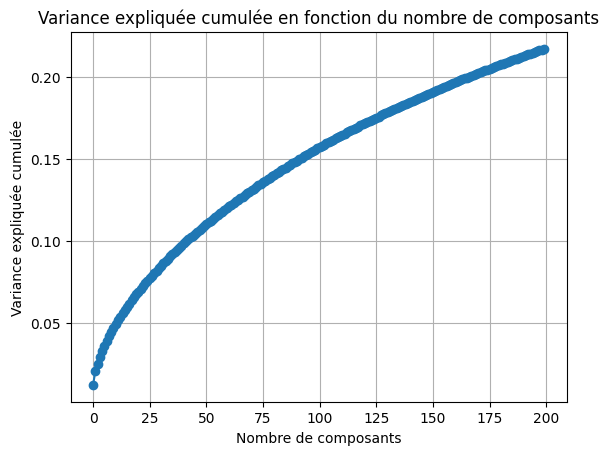

In [6]:
# Réduction de dimensionnalité avec TruncatedSVD
svd = TruncatedSVD(n_components=200)
X_svd = svd.fit_transform(X)
X_test_svd = svd.transform(X_test_v)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_svd)
X_test_scaled = scaler.transform(X_test_svd)

# Calcul de la variance expliquée cumulée
explained_variance_ratio_cumulative = np.cumsum(svd.explained_variance_ratio_)

# Tracé du graphique
plt.plot(explained_variance_ratio_cumulative, marker='o')
plt.title('Variance expliquée cumulée en fonction du nombre de composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.grid(True)
plt.show()

# on observe une très faible variance cumulé malgré 200 composants, cela s'explique
# par l'importante taille des données d'origine (189775)

## Make classification

We will study during this project a small amount of models.

### Logistic regression

The logistic regression is the most simple and naïve model one can use for classification specifically, but it can provide good insights on the baseline one may wish to achieve with more complex models.

**Implement a logistic classifier. Justify every parameter that you choose and how you chose it.**

In [32]:
model_LogReg = MultiOutputClassifier(LogisticRegression())
model_LogReg.fit(X_svd, y_train)


MultiOutputClassifier(estimator=LogisticRegression())

On créé une régression logistique avec les paramêtres de base car ils sont efficaces.

Accuracy: 0.911224470611828
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.48      0.62     15294
           1       0.55      0.21      0.31      1595
           2       0.92      0.56      0.70      8449
           3       0.62      0.01      0.02       478
           4       0.79      0.41      0.54      7877
           5       0.49      0.06      0.10      1405

   micro avg       0.86      0.45      0.59     35098
   macro avg       0.71      0.29      0.38     35098
weighted avg       0.84      0.45      0.58     35098
 samples avg       0.99      0.94      0.93     35098

Accuracy Test: 0.8998405701960048
Classification Report Test:
              precision    recall  f1-score   support

           0       0.70      0.49      0.58      6090
           1       0.30      0.22      0.25       367
           2       0.77      0.51      0.62      3691
           3       0.29      0.01      0.02       211
           4       

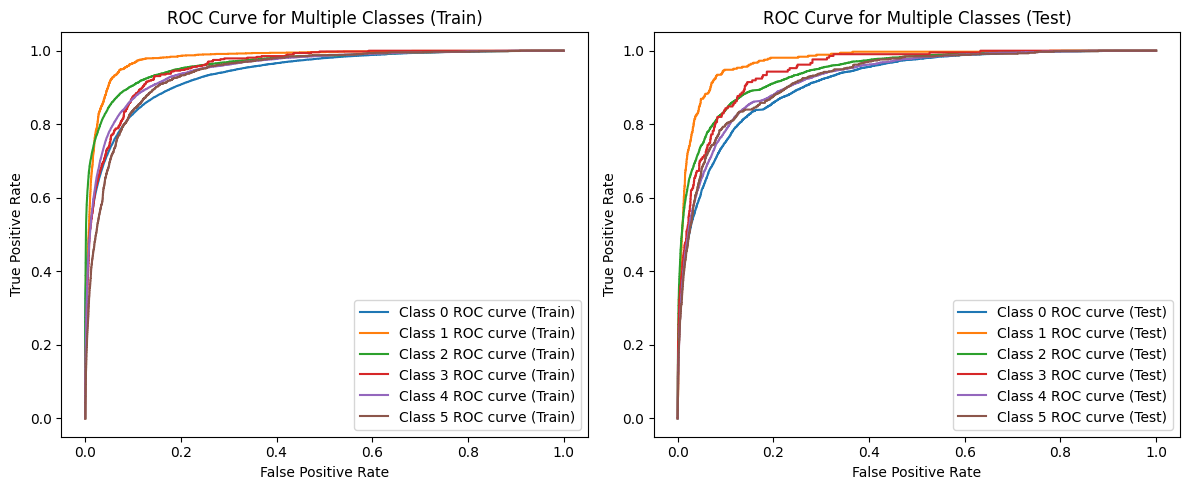

In [33]:
classif_result(model_LogReg,y_train,y_test,X_svd,X_test_svd)

On affiche le résumé de la classification, sur les données d'entraînement et de test. On a aussi affiché la courbe de ROC de chaque catégorie pour les données train et test.
On obtient une accuracy très élevée, mais l'accuracy est faussée dans notre modèle. En effet, l'accuracy n'est pas adaptée lorsque les catégories de données sont inégales, et dans nos données, plus de 80% des commentaires sont normaux.
Il est donc plus intéressant de regarder le f1-score, qui est calculé à partir de la précision et du recall.
La précision est le taux de vrais positifs sur la somme des positifs. Elle évalue donc la capacité du modèle à avoir raison lorsqu'il choisit une classe.
Le recall est le taux de vrais positifs sur la somme des valeures rélles. Il évalue donc la capacité du modèle à détecter le type de toxicité.
Le f1 score est calculé à partir de la précision et du recall, et permet donc de juger le modèle.
La courbe ROC trace le taux de vrais positifs (sensibilité) par rapport au taux de faux positifs (1 - spécificité). Une courbe ROC idéale se rapproche du coin supérieur gauche, indiquant une sensibilité élevée et une spécificité élevée. L'aire sous la courbe (AUC-ROC) mesure la performance globale du modèle, où une valeur de 1.0 représente une performance parfaite et 0.5 indique une performance aléatoire.


On voit donc que notre modèle a une bonne précision au détriment du recall. Cela montre que notre modèle est plutôt prudent dans sa classification. Notre modèle est donc satisfaisant sur certaines catégories, comme la catégorie "toxic", et assez mauvais dans d'autres catégories, comme "menace".

### SVM

The support vector machine used to be the SOTA method for many tasks before neural networks became more popular among data scientists.
Is has a lot of advantages as compared to logistic regression, as it is a kernel method of which the results are still relatively easy to interpret.

**Implement a SVM classifier, justifying your choices of hyper-parameters.**

In [17]:
# Créer un classificateur SVM avec un noyau linéaire
classifier = MultiOutputClassifier(SVC(kernel='linear', decision_function_shape='ovo'))

# Entraîner le classificateur sur les données d'entraînement
classifier.fit(X_svd, y_train)

In [1]:
classif_result(classifier,y_train,y_test,X_svd,X_test_svd)
# Accuracy: 0.9075959917528874
# Classification Report:
#               precision    recall  f1-score   support

#            0       0.93      0.36      0.52     15294
#            1       0.00      0.00      0.00      1595
#            2       0.94      0.49      0.65      8449
#            3       0.00      0.00      0.00       478
#            4       0.79      0.32      0.46      7877
#            5       0.00      0.00      0.00      1405

#    micro avg       0.90      0.35      0.50     35098
#    macro avg       0.44      0.20      0.27     35098
# weighted avg       0.81      0.35      0.49     35098
#  samples avg       0.03      0.03      0.03     35098

NameError: name 'classifier' is not defined

## Other models

**Choose a model between the following:**
* **K-Nearest Neighbors (*KNN*)**
* **Decision Tree**
* **Random Forest**

**Describe IN YOUR OWN WORDS (plagiarism checks will be made if needed) how the method works, and implement it for the current case, discussing its hyperparameters as well.**

In [18]:
#la random forest utilise un bootstrap sur le jeu de donnée, en générant ainsi N (hyperparametre) variations du jeu de données, avec un tirage
# avec ramplacement sur les observations (les lignes) et un tirage aléatoire sur les variables(les colonnes), on obtiens alors N arbres de 
#décision différents, et on utilise la moyenne de résult de tout les arbres pour prédire un résultat.
random_forest_model= MultiOutputClassifier(RandomForestClassifier(n_estimators = 40))
random_forest_model.fit(X_svd, y_train)




MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=40))

In [16]:
classif_result(random_forest_model,y_train,y_test,X_svd,X_test_svd)



Accuracy: 0.9084733441540129
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.31      0.46     15294
           1       0.72      0.15      0.25      1595
           2       0.98      0.37      0.54      8449
           3       1.00      0.01      0.01       478
           4       0.90      0.31      0.46      7877
           5       0.69      0.01      0.01      1405

   micro avg       0.94      0.30      0.45     35098
   macro avg       0.87      0.19      0.29     35098
weighted avg       0.92      0.30      0.45     35098
 samples avg       1.00      0.92      0.92     35098

Accuracy: 0.8935884210197256
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.23      0.33      6090
           1       0.28      0.10      0.15       367
           2       0.83      0.30      0.44      3691
           3       1.00      0.00      0.00       211
           4       0.71     

### Neural Network
Ici on créer un réseau de neuronne avec 1 couche caché de 64 neuronnes. On choisit de faire seulement 10 itération car on a une grande quantité de données donc le modèle aprend beaucoup à chaque itération. On a choisit la fonction d'activation 'logistic' car c'est la plus efficace dans notre cas.
On observe cependant que le modèle est un peu moin bien que la régression logistique. On peut expliquer cela car nous avons choisit de mettre peu de neuronnes et peut de couches. Or il aurait surement été plus efficace d'augmenter cela, mais le temps de calcule devients très vite long. 

In [17]:
model = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(64,), max_iter=10,activation='logistic', random_state=42))
model.fit(X_svd, y_train)

c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\neural_network\_multilayer_p

MultiOutputClassifier(estimator=MLPClassifier(activation='logistic',
                                              hidden_layer_sizes=(64,),
                                              max_iter=10, random_state=42))

In [29]:
joblib.dump(model, 'models/neural_network.pkl')

['models/neural_network.pkl']

In [18]:
classif_result(model,y_train,y_test,X_svd,X_test_svd)

c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9115628779665478
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.53      0.66     15294
           1       0.52      0.27      0.36      1595
           2       0.89      0.63      0.74      8449
           3       0.56      0.01      0.02       478
           4       0.77      0.47      0.58      7877
           5       0.46      0.09      0.15      1405

   micro avg       0.83      0.50      0.63     35098
   macro avg       0.68      0.33      0.42     35098
weighted avg       0.81      0.50      0.62     35098
 samples avg       0.05      0.04      0.04     35098

Accuracy: 0.8949638938385069
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      6090
           1       0.30      0.30      0.30       367
           2       0.71      0.59      0.64      3691
           3       0.50      0.02      0.04       211
           4       0.65     

c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Compare models

One must then compare the models on the test set and provide metrics to study it.

**Compare previously studied models, with counting *tf* and *tf-idf* as vectorizers, for their best hyperparameters.**

On va comparer la méthode de régression logistique et la méthode de forêt aléatoire

Accuracy Test: 0.8998562005689456
Classification Report Test:
              precision    recall  f1-score   support

           0       0.70      0.49      0.57      6090
           1       0.30      0.22      0.25       367
           2       0.78      0.51      0.61      3691
           3       0.29      0.01      0.02       211
           4       0.69      0.35      0.47      3427
           5       0.55      0.11      0.18       712

   micro avg       0.70      0.43      0.53     14498
   macro avg       0.55      0.28      0.35     14498
weighted avg       0.69      0.43      0.52     14498
 samples avg       0.98      0.94      0.92     14498



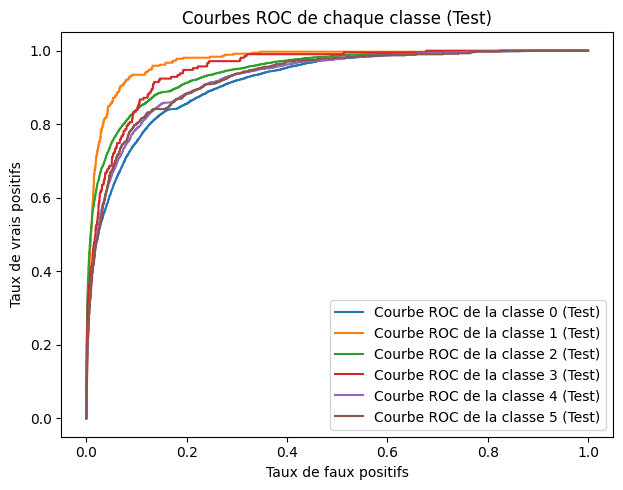

Accuracy Test: 0.8938697677326581
Classification Report Test:
              precision    recall  f1-score   support

           0       0.59      0.19      0.28      6090
           1       0.24      0.08      0.12       367
           2       0.62      0.25      0.35      3691
           3       1.00      0.00      0.00       211
           4       0.72      0.17      0.27      3427
           5       0.33      0.00      0.00       712

   micro avg       0.61      0.18      0.28     14498
   macro avg       0.58      0.11      0.17     14498
weighted avg       0.61      0.18      0.28     14498
 samples avg       0.98      0.92      0.90     14498



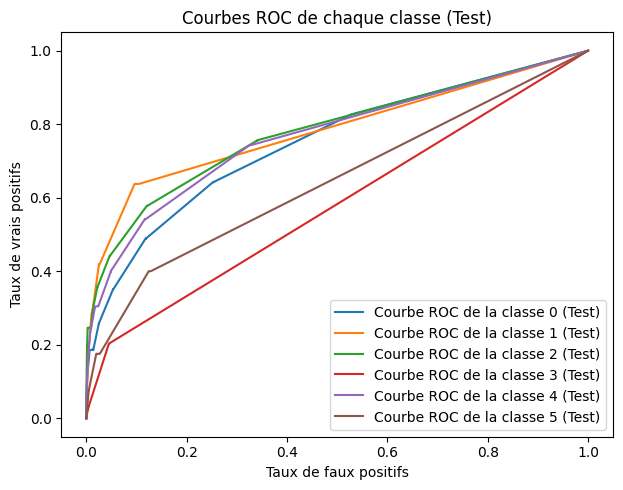

In [35]:
classif_result(model_LogReg,y_train,y_test,X_svd,X_test_svd,train = False)
classif_result(random_forest_model,y_train,y_test,X_svd,X_test_svd,train = False)

La régression logistique a des meilleurs scores de précision que le modèle de forêt aléatoires. Les recalls les f1-scores et l'accuracy sont aussi supérieurs dans la régression logistique. 
Aussi, la régression logistique est bien plus rapide à entrainer que le modèle de forêt aléatoire.

## Use your model

**Use the best model to build a Command-Line Interface (*CLI*) that is launched by the command `./cli.py [options]` using the `argsparse` module, and that accepts in stdin (standard input) english sentences and classifies them, displaying the result and interesting metrics if relevant.**

Nous avons choisi la régression logistique car c'est le meilleur modèle que nous avons trouvé. 

Pour classifier une phrase, Il faut lancer le fichier interface.py et ensuite rentrer la phrase à classifier, le modèle renverra la liste de catégories à laquelle appartient la phrase
